# Object Detection Quantization

This tutorial shows how to quantize an object detection model, using [Post-Training Optimization Tool API](https://docs.openvino.ai/2021.4/pot_compression_api_README.html) in OpenVINO™. 

For demonstration purposes, a very small dataset of 10 images presenting people at the airport is used. The images have been resized from the original resolution of 1920x1080 to 960x540. For any real use cases, a representative dataset of about 300 images is recommended. The tutorial uses the [person-detection-retail-0013](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/person-detection-retail-0013) model.

## Preparation

### Imports

In [2]:
import json
import sys
import time
from pathlib import Path
from typing import Sequence, Tuple

import addict
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
from compression.api import DataLoader, Metric
from compression.engines.ie_engine import IEEngine
from compression.graph import load_model, save_model
from compression.graph.model_utils import compress_model_weights
from compression.pipeline.initializer import create_pipeline
from openvino.runtime import Core
from yaspin import yaspin

sys.path.append("../utils")
from notebook_utils import benchmark_model

### Download Model

Download the model from Open Model Zoo if it is not already in the system.

In [3]:
ir_path = Path("intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml")

if not ir_path.exists():
    ! omz_downloader --name "person-detection-retail-0013" --precisions FP32

################|| Downloading person-detection-retail-0013 ||################

========== Downloading /raid/didir/Repository/openvino_notebooks/notebooks/111-detection-quantization/intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml
... 100%, 459 KB, 447 KB/s, 1 seconds passed

========== Downloading /raid/didir/Repository/openvino_notebooks/notebooks/111-detection-quantization/intel/person-detection-retail-0013/FP32/person-detection-retail-0013.bin
... 100%, 2823 KB, 4025 KB/s, 0 seconds passed



### Load Model

Load the OpenVINO IR model, and get information about network inputs and outputs.

In [4]:
ie = Core()
model = ie.read_model(model=ir_path)
compiled_model = ie.compile_model(model=model, device_name="CPU")
input_layer = compiled_model.input(0)
output_layer = compiled_model.output(0)
input_size = input_layer.shape
print(f"Input Size: {input_size}")
_, _, input_height, input_width = input_size

Input Size: {1, 3, 320, 544}


## Post-Training Optimization Tool (POT) Quantization

The Post-Training Optimization Tool (POT) `compression` API defines base classes for `Metric` and `DataLoader`. This notebook uses a custom `Metric` and `DataLoader` class that implement all the required methods.

To implement `Metric` and `Dataloader`, you need to know the outputs of the model and the annotation format.

The dataset in this example uses annotations in `JSON` format, with keys: `['categories', 'annotations', 'images']`. The `annotations` key is a list of dictionaries, with one item per annotation. Such item contains a `boxes` key, which holds the prediction boxes, in the `[xmin, xmax, ymin, ymax]` format. In this dataset, there is only one label: "person". 

The [model documentation](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/person-detection-retail-0013) specifies that the model returns an array of shape `[1, 1, 200, 7]` where 200 is the number of detected boxes. Each detection has the format of `[image_id, label, conf, x_min, y_min, x_max, y_max]`. For this dataset, the label of `1` indicates a person.

### Configuration

#### Dataset

The `DetectionDataLoader` class follows `compression.api.DataLoader` interface in POT, which should implement `__init__`, `__getitem__` and `__len__`, where `__getitem__` should return data as `(annotation, image)` or optionally `(annotation, image, metadata)`, with the annotation as `(index, label)`. 

In [5]:
class DetectionDataLoader(DataLoader):
    def __init__(self, basedir: str, target_size: Tuple[int, int]):
        """
        :param basedir: Directory that contains images and annotation as "annotation.json"
        :param target_size: Tuple of (width, height) to resize images to.
        """
        self.images = sorted(Path(basedir).glob("*.jpg"))
        self.target_size = target_size
        with open(f"{basedir}/annotation_person_train.json") as f:
            self.annotations = json.load(f)
        self.image_ids = {
            Path(item["file_name"]).name: item["id"]
            for item in self.annotations["images"]
        }

        for image_filename in self.images:
            annotations = [
                item
                for item in self.annotations["annotations"]
                if item["image_id"] == self.image_ids[Path(image_filename).name]
            ]
            assert (
                len(annotations) != 0
            ), f"No annotations found for image id {image_filename}"

        print(
            f"Created dataset with {len(self.images)} items. Data directory: {basedir}"
        )

    def __getitem__(self, index):
        """
        Get an item from the dataset at the specified index.
        Detection boxes are converted from absolute coordinates to relative coordinates
        between 0 and 1 by dividing xmin, xmax by image width and ymin, ymax by image height.

        :return: (annotation, input_image, metadata) where annotation is (index, target_annotation)
                 with target_annotation as a dictionary with keys category_id, image_width, image_height
                 and bbox, containing the relative bounding box coordinates [xmin, ymin, xmax, ymax]
                 (with values between 0 and 1) and metadata a dictionary: {"filename": path_to_image}
        """
        image_path = self.images[index]
        image = cv2.imread(str(image_path))
        image = cv2.resize(image, self.target_size)
        image_id = self.image_ids[Path(image_path).name]

        # The `image_info` key contains height and width of the annotated image.
        image_info = [
            image for image in self.annotations["images"] if image["id"] == image_id
        ][0]
        # The `image_annotations` key contains the boxes and labels for the image.
        image_annotations = [
            item
            for item in self.annotations["annotations"]
            if item["image_id"] == image_id
        ]

        # The annotations are in xmin, ymin, width, height format. Convert to
        # xmin, ymin, xmax, ymax and normalize to image width and height as
        # stored in the annotation.
        target_annotations = []
        for annotation in image_annotations:
            xmin, ymin, width, height = annotation["bbox"]
            xmax = xmin + width
            ymax = ymin + height
            xmin /= image_info["width"]
            ymin /= image_info["height"]
            xmax /= image_info["width"]
            ymax /= image_info["height"]
            target_annotation = {}
            target_annotation["category_id"] = annotation["category_id"]
            target_annotation["image_width"] = image_info["width"]
            target_annotation["image_height"] = image_info["height"]
            target_annotation["bbox"] = [xmin, ymin, xmax, ymax]
            target_annotations.append(target_annotation)

        item_annotation = (index, target_annotations)
        input_image = np.expand_dims(image.transpose(2, 0, 1), axis=0).astype(
            np.float32
        )
        return (
            item_annotation,
            input_image,
            {"filename": str(image_path), "shape": image.shape},
        )

    def __len__(self):
        return len(self.images)

#### Metric

Define a metric to determine the performance of a model. For the Default Quantization algorithm used in this notebook, defining a metric is optional, but it can be used to compare the quantized `INT8` model with the original FP OpenVINO IR model.

This tutorial uses the Mean Average Precision (MAP) metric from [TorchMetrics](https://torchmetrics.readthedocs.io/en/latest/references/modules.html#detection-metrics).

A metric for POT inherits from `compression.api.Metric` and should implement all the methods in this example.

In [19]:
class MAPMetric(Metric):
    def __init__(self, map_value="map"):
        """
        Mean Average Precision Metric. Wraps torchmetrics implementation, see
        https://torchmetrics.readthedocs.io/en/latest/references/modules.html#map

        :map_value: specific metric to return. Default: "map"
                    Change `to one of the values in the list below to return a different value
                    ['mar_1', 'mar_10', 'mar_100', 'mar_small', 'mar_medium', 'mar_large',
                     'map', 'map_50', 'map_75', 'map_small', 'map_medium', 'map_large']
                    See torchmetrics documentation for more details.
        """
        # assert (
        #     map_value
        #     in torchmetrics.detection.mean_ap.MARMetricResults.__slots__
        #     + torchmetrics.detection.mean_ap.MAPMetricResults.__slots__
        # )

        self._name = map_value
        self.metric = torchmetrics.detection.mean_ap.MeanAveragePrecision()
        super().__init__()

    @property
    def value(self):
        """
        Returns metric value for the last model output.
        Possible format: {metric_name: [metric_values_per_image]}
        """
        return {self._name: [0]}

    @property
    def avg_value(self):
        """
        Returns average metric value for all model outputs.
        Possible format: {metric_name: metric_value}
        """
        return {self._name: self.metric.compute()[self._name].item()}

    def update(self, output, target):
        """
        Convert network output and labels to the format that torchmetrics' MAP
        implementation expects, and call `metric.update()`.

        :param output: model output
        :param target: annotations for model output
        """
        targetboxes = []
        targetlabels = []
        predboxes = []
        predlabels = []
        scores = []

        image_width = target[0][0]["image_width"]
        image_height = target[0][0]["image_height"]

        for single_target in target[0]:
            txmin, tymin, txmax, tymax = single_target["bbox"]
            category = single_target["category_id"]
            txmin *= image_width
            txmax *= image_width
            tymin *= image_height
            tymax *= image_height

            targetbox = [round(txmin), round(tymin), round(txmax), round(tymax)]
            targetboxes.append(targetbox)
            targetlabels.append(category)

        for single_output in output:
            for pred in single_output[0, 0, ::]:
                image_id, label, conf, xmin, ymin, xmax, ymax = pred
                xmin *= image_width
                xmax *= image_width
                ymin *= image_height
                ymax *= image_height

                predbox = [round(xmin), round(ymin), round(xmax), round(ymax)]
                predboxes.append(predbox)
                predlabels.append(label)
                scores.append(conf)

        preds = [
            dict(
                boxes=torch.Tensor(predboxes).float(),
                labels=torch.Tensor(predlabels).short(),
                scores=torch.Tensor(scores),
            )
        ]
        targets = [
            dict(
                boxes=torch.Tensor(targetboxes).float(),
                labels=torch.Tensor(targetlabels).short(),
            )
        ]
        self.metric.update(preds, targets)

    def reset(self):
        """
        Resets metric
        """
        self.metric.reset()

    def get_attributes(self):
        """
        Returns a dictionary of metric attributes {metric_name: {attribute_name: value}}.
        Required attributes: 'direction': 'higher-better' or 'higher-worse'
                             'type': metric type
        """
        return {self._name: {"direction": "higher-better", "type": "mAP"}}

#### Quantization Config

The POT methods expect configuration dictionaries as arguments, which are defined in the cell below. The `ir_path` variable points to the `.xml` file of the OpenVINO IR model. It is defined at the top of the notebook. This tutorial uses the `DefaultQuantization` algorithm.

For more information about the settings and best practices, refer to the [Post-Training Optimization Best Practices](https://docs.openvino.ai/2021.4/pot_docs_BestPractices.html) and the main [POT documentation](https://docs.openvino.ai/2021.4/pot_README.html).

In [20]:
# Model config specifies the name of the model and paths to `.xml` and `.bin` files of the model.
model_config = addict.Dict(
    {
        "model_name": ir_path.stem,
        "model": ir_path,
        "weights": ir_path.with_suffix(".bin"),
    }
)

# Engine config
engine_config = addict.Dict({"device": "CPU"})

# Standard DefaultQuantization config. For this tutorial, stat_subset_size is ignored
# because there are fewer than 300 images. For production use, 300 is recommended.
default_algorithms = [
    {
        "name": "DefaultQuantization",
        "stat_subset_size": 300,
        "params": {
            "target_device": "ANY",
            "preset": "mixed",  # Choose between "mixed" and "performance".
        },
    }
]

print(f"model_config: {model_config}")

model_config: {'model_name': 'person-detection-retail-0013', 'model': PosixPath('intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml'), 'weights': PosixPath('intel/person-detection-retail-0013/FP32/person-detection-retail-0013.bin')}


### Run Quantization Pipeline

The POT pipeline uses the functions: `load_model()`, `IEEngine`, and `create_pipeline()`. The `load_model()` function loads an OpenVINO IR model specified in `model_config`. `IEEngine` is a POT implementation of OpenVINO Runtime that will be passed to the POT pipeline created by the `create_pipeline()` function. The POT classes and functions expect a config argument. These configs are created in the Config section in the cell above. `MAPMetric` metric and `DetectionDataLoader` have been defined earlier in this notebook.

Creating and running the POT quantization pipeline takes just two lines of code. First, create the pipeline with the `create_pipeline` function, and then run that pipeline with `pipeline.run()`. To reuse the quantized model later, compress the model weights and save the compressed model to a disk.

In [21]:
# Step 1: Create the data loader.
data_loader = DetectionDataLoader(
    basedir="data", target_size=(input_width, input_height)
)

# Step 2: Load the model.
ir_model = load_model(model_config=model_config)

# Step 3: Initialize the metric.
# For DefaultQuantization, specifying a metric is optional: metric can be set to None.
metric = MAPMetric(map_value="map")

# Step 4: Initialize the engine for metric calculation and statistics collection.
engine = IEEngine(config=engine_config, data_loader=data_loader, metric=metric)

# Step 5: Create a pipeline of compression algorithms.
# The `default_algorithms` parameter is defined in the Config cell above this cell.
pipeline = create_pipeline(default_algorithms, engine)

# Step 6: Execute the pipeline to quantize the model.
algorithm_name = pipeline.algo_seq[0].name
with yaspin(
    text=f"Executing POT pipeline on {model_config['model']} with {algorithm_name}"
) as sp:
    start_time = time.perf_counter()
    compressed_model = pipeline.run(ir_model)
    end_time = time.perf_counter()
    sp.ok("✔")
print(f"Quantization finished in {end_time - start_time:.2f} seconds")

# Step 7 (Optional): Compress model weights to quantized precision
#                    in order to reduce the size of the final `.bin` file.
compress_model_weights(compressed_model)

# Step 8: Save the compressed model to the desired path.
# Set `save_path` to the directory where the compressed model should be stored.
preset = pipeline._algo_seq[0].config["preset"]
algorithm_name = pipeline.algo_seq[0].name
compressed_model_paths = save_model(
    model=compressed_model,
    save_path="optimized_model",
    model_name=f"{ir_model.name}_{preset}_{algorithm_name}",
)

compressed_model_path = compressed_model_paths[0]["model"]
print("The quantized model is stored at", compressed_model_path)

Created dataset with 10 items. Data directory: data
✔ Executing POT pipeline on intel/person-detection-retail-0013/FP32/person-detection-retail-0013.xml with DefaultQuantization 
Quantization finished in 60.47 seconds
The quantized model is stored at optimized_model/person-detection-retail-0013_mixed_DefaultQuantization.xml


## Compare Metric of Floating Point and Quantized Model

In [22]:
# Compute the mAP on the quantized model and compare with the mAP on the FP16 OpenVINO IR model.
ir_model = load_model(model_config=model_config)
evaluation_pipeline = create_pipeline(algo_config=dict(), engine=engine)

with yaspin(text="Evaluating original IR model") as sp:
    original_metric = evaluation_pipeline.evaluate(ir_model)

with yaspin(text="Evaluating quantized IR model") as sp:
    quantized_metric = pipeline.evaluate(compressed_model)

if original_metric:
    for key, value in original_metric.items():
        print(f"The {key} score of the original FP16 model is {value:.5f}")

if quantized_metric:
    for key, value in quantized_metric.items():
        print(f"The {key} score of the quantized INT8 model is {value:.5f}")

The map score of the original FP16 model is 0.67329
The map score of the quantized INT8 model is 0.66534


## Visualize Results

Compare the annotated boxes (green) with the results of the floating point (red) and quantized (green) models. First, define a helper function to draw the boxes on an image, using the specified color. Then, do inference on five images and show the results. The figure shows three images for every input image: the left image shows the annotation and both `FP` and `INT8` predictions, the middle image shows the floating point model prediction separately, and the image to the right shows the quantized model prediction. The mAP score of the prediction is shown with each prediction. Predicted boxes with a confidence value of at least 0.5 will be shown.

In [23]:
def draw_boxes_on_image(
    box: Sequence[float], image: np.ndarray, color: str, scale: bool = True
):
    """
    Draw a `box` on an `image` with a `color`, optionally scaling the box from normalized
    coordinates (between 0 and 1) to image coordinates.
    This is a utility function for binary detection where all boxes belong to one category.

    :param box: Box coordinates as [xmin, ymin, xmax, ymax]
    :param image: numpy array of RGB image
    :param color: Box color, "red", "green" or "blue"
    "param scale: If True, scale normalized box coordinates to absolute coordinates based
                  on the image size.
    """
    colors = {"red": (255, 0, 64), "green": (0, 255, 0), "yellow": (255, 255, 128)}
    assert color in colors, f"{color} is not defined yet. Defined colors are: {colors}"
    image_height, image_width, _ = image.shape
    x_min, y_min, x_max, y_max = box
    if scale:
        x_min *= image_width
        x_max *= image_width
        y_min *= image_height
        y_max *= image_height

    image = cv2.rectangle(
        img=image,
        pt1=(round(x_min), round(y_min)),
        pt2=(round(x_max), round(y_max)),
        color=colors[color],
        thickness=2,
    )
    return image

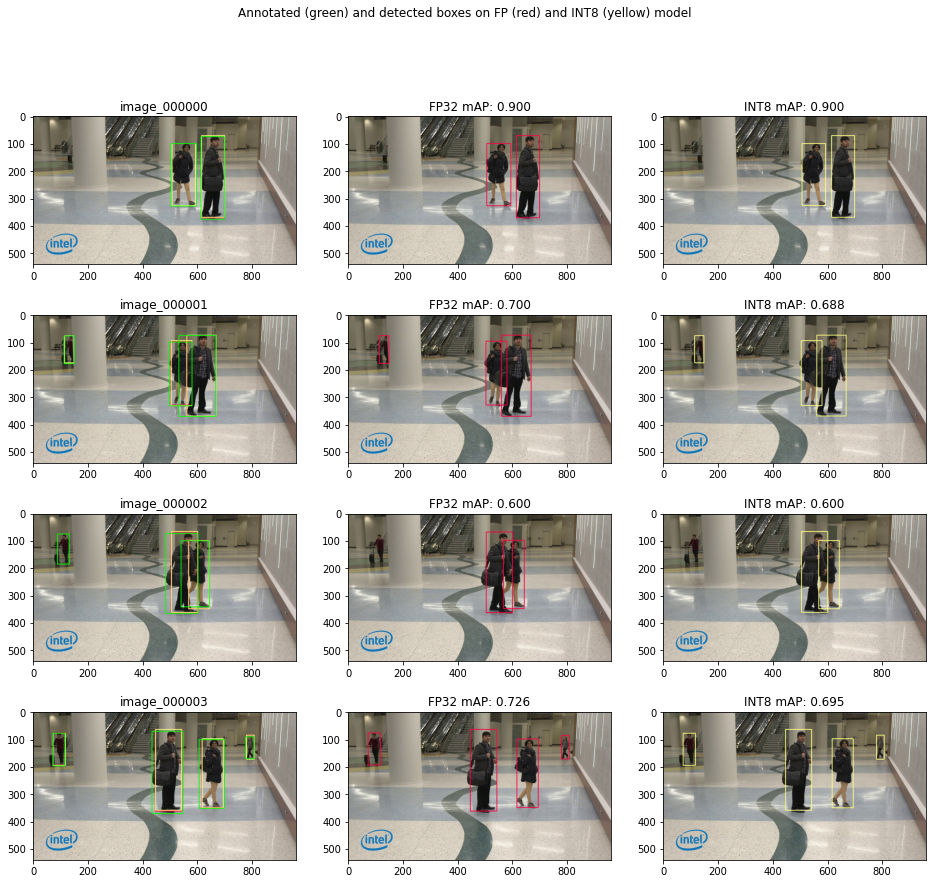

In [24]:
# Change `map_value` to one of the values in the list below to show a different metric.
# See https://torchmetrics.readthedocs.io/en/latest/references/modules.html#map
# ('map', 'map_50', 'map_75', 'map_small', 'map_medium', 'map_large'
#  'mar_1', 'mar_10', 'mar_100', 'mar_small', 'mar_medium', 'mar_large')

map_value = "map"
confidence_threshold = 0.5
num_images = 4

# FP prediction
fp_model = ie.read_model(model=ir_path)
fp_compiled_model = ie.compile_model(model=fp_model, device_name="CPU")
input_layer_fp = fp_compiled_model.input(0)
output_layer_fp = fp_compiled_model.output(0)

# INT8 prediction
int8_model = ie.read_model(model=compressed_model_path)
int8_compiled_model = ie.compile_model(model=int8_model, device_name="CPU")
input_layer_int8 = int8_compiled_model.input(0)
output_layer_int8 = int8_compiled_model.output(0)

fig, axs = plt.subplots(nrows=num_images, ncols=3, figsize=(16, 14), squeeze=False)
for i in range(num_images):
    annotation, input_image, metadata = data_loader[i]
    image = cv2.cvtColor(
        src=cv2.imread(filename=metadata["filename"]), code=cv2.COLOR_BGR2RGB
    )
    orig_image = image.copy()
    resized_image = cv2.resize(image, (input_width, input_height))
    target_annotation = annotation[1]

    fp_res = fp_compiled_model([input_image])[output_layer_fp]
    
    fp_metric = MAPMetric(map_value=map_value)
    fp_metric.update(output=[fp_res], target=[target_annotation])

    for item in fp_res[0, 0, ::]:
        _, _, conf, xmin, xmax, ymin, ymax = item
        if conf > confidence_threshold:
            total_image = draw_boxes_on_image([xmin, xmax, ymin, ymax], image, "red")

    axs[i, 1].imshow(total_image)

    int8_res = int8_compiled_model([input_image])[output_layer_int8]
    int8_metric = MAPMetric(map_value=map_value)
    int8_metric.update(output=[int8_res], target=[target_annotation])

    for item in int8_res[0, 0, ::]:
        _, _, conf, xmin, xmax, ymin, ymax = item
        if conf > confidence_threshold:
            total_image = draw_boxes_on_image(
                [xmin, xmax, ymin, ymax], total_image, "yellow"
            )
            int8_image = draw_boxes_on_image(
                [xmin, xmax, ymin, ymax], orig_image, "yellow"
            )

    axs[i, 2].imshow(int8_image)

    # Annotation
    for annotation in target_annotation:
        total_image = draw_boxes_on_image(annotation["bbox"], total_image, "green")

    axs[i, 0].imshow(image)
    axs[i, 0].set_title(Path(metadata["filename"]).stem)
    axs[i, 1].set_title(f"FP32 mAP: {fp_metric.avg_value[map_value]:.3f}")
    axs[i, 2].set_title(f"INT8 mAP: {int8_metric.avg_value[map_value]:.3f}")
    fig.suptitle(
        "Annotated (green) and detected boxes on FP (red) and INT8 (yellow) model"
    )

## Compare the Size of the Original and Quantized Models

In [25]:
original_model_size = Path(ir_path).with_suffix(".bin").stat().st_size / 1024
quantized_model_size = (
    Path(compressed_model_path).with_suffix(".bin").stat().st_size / 1024
)

print(f"FP32 model size: {original_model_size:.2f} KB")
print(f"INT8 model size: {quantized_model_size:.2f} KB")

FP32 model size: 2823.60 KB
INT8 model size: 806.62 KB


## Compare Performance of the Original and Quantized Models

To measure inference performance of the `FP16` and `INT8` models, use the [Benchmark Tool](https://docs.openvino.ai/latest/openvino_inference_engine_tools_benchmark_tool_README.html) in OpenVINO. It can be run in the notebook with the `! benchmark_app` or `%sx benchmark_app` commands.

This tutorial uses a wrapper function from [Notebook Utils](https://github.com/openvinotoolkit/openvino_notebooks/blob/main/notebooks/utils/notebook_utils.ipynb). It prints the `benchmark_app` command with the chosen parameters.

> **Note**: For the most accurate performance estimation, it is recommended to run `benchmark_app` in a terminal/command prompt after closing other applications. Run `benchmark_app --help` to see all command-line options.

In [ ]:
# ! benchmark_app --help

In [ ]:
# benchmark_model??

In [ ]:
# Benchmark FP16 model
benchmark_model(model_path=ir_path, device="CPU", seconds=15, api="async")

In [ ]:
# Benchmark INT8 model
benchmark_model(model_path=compressed_model_path, device="CPU", seconds=15, api="async")

In [ ]:
# Benchmark INT8 model on MULTI:CPU,GPU device (requires an Intel integrated GPU)
ie = Core()
if "GPU" in ie.available_devices:
    benchmark_model(
        model_path=compressed_model_path,
        device="MULTI:CPU,GPU",
        seconds=15,
        api="async",
        batch=4,
    )